<a href="https://colab.research.google.com/github/sageeh/Amazon_Review_similarity/blob/main/Amazon_book_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install -r requirement.txt

In [21]:
import os
import pandas as pd
import re
from itertools import combinations
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata



In [11]:
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

DATASET_LINK = "mohamedbakhet/amazon-books-reviews"
CSV_FILE_NAME = "Books_rating.csv"
SUBSAMPLE_DATA = True
SUBSAMPLE_SIZE = 30000
# MinHash Parameters
NUM_PERMUTATIONS = 128  # Number of hash functions for MinHashing. Higher = more accurate, slower
MINHASH_PRIME_MODULO = 2**31 - 1 # A large prime number for hash calculations (should be smaller than 2**32 - 1)
# LSH Parameters
NUM_BANDS = 32  # Number of bands for LSH
# make sure that NUM_PERMUTATIONS is divisible by NUM_BANDS
if NUM_PERMUTATIONS % NUM_BANDS != 0:
    raise ValueError("NUM_PERMUTATIONS must be divisible by NUM_BANDS")
ROWS_PER_BAND = NUM_PERMUTATIONS // NUM_BANDS  # Rows per band
SIMILARITY_THRESHOLD = 0.6  # Define a threshold for considering pairs "similar"
TOP_N_SIMILAR_PAIRS = 10 # Number of top similar pairs to display
k_shingle_size= 1# k-shingle size for text preprocessing


In [13]:
def download_and_load_data(dataset_link, csv_file_name, subsample, subsample_size):
    if not os.path.exists(csv_file_name):
      print(f"Downloading dataset: {dataset_link}...")
      !kaggle datasets download -d {dataset_link}
      dataset_zip_name = dataset_link.split('/')[-1] + '.zip'
      print(f"Unzipping {dataset_zip_name}...")
      !unzip -o {dataset_zip_name} # -o to overwrite if already exists

    print(f"Loading {csv_file_name} into DataFrame...")
    try:
        df = pd.read_csv(csv_file_name)
    except FileNotFoundError:
        print(f"Error: {csv_file_name} not found. Make sure it's in the current directory after unzipping.")
        return None

    if subsample:
        print(f"Subsampling dataset to {subsample_size} reviews...")
        # Drop rows with missing 'review/text' before subsampling to avoid errors
        df_filtered = df.dropna(subset=['review/text'])
        # df_review = df_filtered['review/text']
        # print(df_review[:5])
        if len(df_filtered) > subsample_size:
            df = df_filtered.sample(n=subsample_size, random_state=42).reset_index(drop=True)
        else:
            df = df_filtered.reset_index(drop=True)
            print(f"Dataset has fewer than {subsample_size} reviews after filtering, using all {len(df)} available.")
    else:
        df = df.dropna(subset=['review/text']).reset_index(drop=True)
        print(f"Using the full dataset with {len(df)} reviews after filtering.")

    return df

In [14]:
def preprocess_text(text, k_shingle_size):

    if not isinstance(text, str):
        return set()
    text = text.lower()
    # Remove non-alphanumeric characters (keep spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()

    if k_shingle_size <= 0:
        return set(words) # Return individual words if k_shingle_size is invalid or 0

    shingles = set()
    for i in range(len(words) - k_shingle_size + 1):
        shingle = " ".join(words[i : i + k_shingle_size])
        shingles.add(shingle)
    return shingles

In [15]:
class MinHasher:
    """
    Implements MinHashing to create signatures for sets of shingles.
    """
    def __init__(self, num_permutations, prime_modulo, seed=42):
        self.num_permutations = num_permutations
        self.prime_modulo = prime_modulo

         # Generate random hash coefficients for universal hashing
        # This is a common approximation for random permutations in practice
        rng = np.random.default_rng(seed) # Use modern numpy random generator
        self.hash_coeffs_a = rng.integers(1, self.prime_modulo - 1, size=num_permutations, dtype=np.int64)
        self.hash_coeffs_b = rng.integers(0, self.prime_modulo - 1, size=num_permutations, dtype=np.int64)

    def _hash_shingle(self, shingle_str):

     # Ensure the hash value fits within positive integer range for modulo
        # abs(hash(shingle_str)) handles potential negative hash values from Python's hash()
        return abs(hash(shingle_str)) % self.prime_modulo

    def get_signature(self, shingle_set):

        if not shingle_set:
            return np.full(self.num_permutations, float('inf')).tolist()

        # Pre-calculate base hash values for each shingle
        shingle_hashes = np.array([self._hash_shingle(shingle) for shingle in shingle_set], dtype=np.int64)

        # Apply all hash functions to all shingle hashes simultaneously
        hashed_values = (self.hash_coeffs_a[:, np.newaxis] * shingle_hashes + self.hash_coeffs_b[:, np.newaxis]) % self.prime_modulo

        # Find the minimum hash value for each permutation across all shingles
        signature = np.min(hashed_values, axis=1)

        return signature.tolist()

    @staticmethod
    def calculate_minhash_jaccard_similarity(sig1, sig2):
        if not sig1 or not sig2:
            return 0.0

        sig1_np = np.array(sig1)
        sig2_np = np.array(sig2)

        # Ensure signatures are of the same length
        if len(sig1_np) != len(sig2_np):
            raise ValueError("MinHash signatures must have the same number of permutations.")

        matching_hashes = np.sum(sig1_np == sig2_np)
        return matching_hashes / len(sig1_np)

In [16]:
class LSHIndex:
    def __init__(self, num_bands, rows_per_band):

        self.num_bands = num_bands
        self.rows_per_band = rows_per_band
        self.hash_tables = [{} for _ in range(num_bands)] # A hash table for each band

    def index(self, signatures_with_ids):
        print(f"Indexing {len(signatures_with_ids)} signatures with LSH ({self.num_bands} bands, {self.rows_per_band} rows per band)...")
        for doc_id, signature in signatures_with_ids:
            # Check if the signature has the expected length
            if len(signature) != self.num_bands * self.rows_per_band:
                print(f"Warning: Signature for doc_id {doc_id} has unexpected length. Skipping.")
                continue

            for i in range(self.num_bands):
                band_start = i * self.rows_per_band
                band_end = band_start + self.rows_per_band
                band_slice = tuple(signature[band_start:band_end]) # Use tuple for hashability

                bucket_key = hash(band_slice)

                if bucket_key not in self.hash_tables[i]:
                    self.hash_tables[i][bucket_key] = []
                self.hash_tables[i][bucket_key].append(doc_id)
        print("LSH indexing complete.")

    def query_candidates(self, minhash_signatures_dict):
        candidate_pairs = set()

        for doc_id, signature in minhash_signatures_dict.items():
            for i in range(self.num_bands):
                band_start = i * self.rows_per_band
                band_end = band_start + self.rows_per_band
                band_slice = tuple(signature[band_start:band_end])

                bucket_key = hash(band_slice)

                if bucket_key in self.hash_tables[i]:
                    # All items in this bucket are candidates
                    for candidate_id in self.hash_tables[i][bucket_key]:
                        if candidate_id != doc_id: # Don't compare with self
                            # Ensure pair is ordered to avoid duplicates (e.g., (1,2) and (2,1))
                            pair = tuple(sorted((doc_id, candidate_id)))
                            candidate_pairs.add(pair)
        return candidate_pairs

In [17]:
if __name__ == "__main__":
    start_time_total = time.time()

    # 1. Download and Load Data
    reviews_df = download_and_load_data(DATASET_LINK, CSV_FILE_NAME, SUBSAMPLE_DATA, SUBSAMPLE_SIZE)

    if reviews_df is None or reviews_df.empty:
        print("No data to process. Exiting.")
    else:
        print(f"Number of reviews loaded to DataFrame: {len(reviews_df)}")
        print("First 5 reviews:")
        for i in range(min(5, len(reviews_df))):
            print(f"Review {reviews_df.index[i]}: {reviews_df['review/text'].iloc[i][:100]}...")

        # --- Generate MinHash Signatures ---
        print(f"\nPreprocessing and Generating MinHash signatures with {NUM_PERMUTATIONS} permutations...")
        start_time_shingling_minhashing = time.time()

        minhasher = MinHasher(NUM_PERMUTATIONS, MINHASH_PRIME_MODULO, seed=42)
        minhash_signatures = {}
        for index, row in reviews_df.iterrows():
            doc_id = index
            review_text = row['review/text']
            shingles = preprocess_text(review_text,k_shingle_size)
            signature = minhasher.get_signature(shingles)
            minhash_signatures[doc_id] = signature

        end_time_shingling_minhashing = time.time()
        print(f"Shingling and MinHashing complete in {end_time_shingling_minhashing - start_time_shingling_minhashing:.2f} seconds.")

        # --- LSH Indexing ---
        print(f"\nBuilding LSH index with {NUM_BANDS} bands and {ROWS_PER_BAND} rows per band...")
        start_time_lsh_index = time.time()
        lsh_index = LSHIndex(NUM_BANDS, ROWS_PER_BAND)
        lsh_index.index(list(minhash_signatures.items()))
        end_time_lsh_index = time.time()
        print(f"LSH indexing complete in {end_time_lsh_index - start_time_lsh_index:.2f} seconds.")

        # --- Find Candidate Pairs using LSH Query ---
        print("\nFinding candidate pairs using LSH query...")
        start_time_lsh_query = time.time()

        candidate_pairs = lsh_index.query_candidates(minhash_signatures)

        end_time_lsh_query = time.time()
        print(f"LSH query complete in {end_time_lsh_query - start_time_lsh_query:.2f} seconds.")
        print(f"Found {len(candidate_pairs)} candidate pairs.")

        # Calculate the total number of possible unique pairs in the dataset
        n = len(reviews_df)
        total_possible_pairs = n * (n - 1) // 2 if n > 1 else 0
        if total_possible_pairs > 0:
            reduction_percentage = ((total_possible_pairs - len(candidate_pairs)) / total_possible_pairs) * 100
            print(f"Reduced number of comparisons by {reduction_percentage:.2f}% from {total_possible_pairs} possible pairs.")
        else:
            print("Not enough reviews to form pairs.")

        # --- Verify Candidates with MinHash Jaccard Similarity ---
        print("\nVerifying candidate pairs with MinHash Jaccard similarity...")
        start_time_verification = time.time()

        final_similar_pairs = []
        num_minhash_comparisons = 0
        for doc_id1, doc_id2 in candidate_pairs:
            num_minhash_comparisons += 1
            minhash_sig1 = minhash_signatures.get(doc_id1)
            minhash_sig2 = minhash_signatures.get(doc_id2)

            if minhash_sig1 is not None and minhash_sig2 is not None:
                # Calculate approximate Jaccard similarity using MinHash signatures
                similarity = MinHasher.calculate_minhash_jaccard_similarity(minhash_sig1, minhash_sig2)
                if similarity >= SIMILARITY_THRESHOLD:
                    final_similar_pairs.append((doc_id1, doc_id2, similarity))

        end_time_verification = time.time()
        print(f"Verification complete in {end_time_verification - start_time_verification:.2f} seconds.")
        print(f"Performed {num_minhash_comparisons} MinHash comparisons.")
        print(f"Found {len(final_similar_pairs)} truly similar pairs with MinHash similarity >= {SIMILARITY_THRESHOLD}.")

        # Sort the final similar pairs by their similarity score in descending order
        final_similar_pairs.sort(key=lambda x: x[2], reverse=True)

        # Display the top N most similar review pairs
        print(f"\nTop {TOP_N_SIMILAR_PAIRS} most similar review pairs (MinHash Similarity >= {SIMILARITY_THRESHOLD}):")
        if final_similar_pairs:
            for r1_idx, r2_idx, score in final_similar_pairs[:TOP_N_SIMILAR_PAIRS]:
                print(f"  Similarity: {score:.4f} between Review {r1_idx} and Review {r2_idx}")
                # Attempt to print a snippet of the origin al review text for context
                # Ensure indices exist in the DataFrame before accessing (using .loc ensures proper index lookup)
                review_text1 = reviews_df.loc[r1_idx, 'review/text'] if r1_idx in reviews_df.index else "Review text not found."
                review_text2 = reviews_df.loc[r2_idx, 'review/text'] if r2_idx in reviews_df.index else "Review text not found."
                print(f"    Review {r1_idx}: {review_text1[:150]}...")
                print(f"    Review {r2_idx}: {review_text2[:150]}...")
                print("-" * 50)
        else:
            print("No similar pairs found above the threshold.")

    end_time_total = time.time()
    print(f"\nTotal execution time: {end_time_total - start_time_total:.2f} seconds.")

Loading Books_rating.csv into DataFrame...
Subsampling dataset to 30000 reviews...
Number of reviews loaded: 30000
First 5 reviews (raw text):
Review 0: This book is a prime example of how horribly written, deeply unpleasant books gain standing as child...
Review 1: Extremely disappointed by the SHORT length and cursory information of this video.The barista knows h...
Review 2: I will openly admit that I have never seen the Punch and Judy story, and I haven't got the faintest ...
Review 3: I loved this book so much that I selected it as the first choice in our blog post on NileGuide (www....
Review 4: Perhaps the best book on the market for passing the PMP exam, bar none! This book is also a keeper f...

Preprocessing and Generating MinHash signatures with 128 permutations...
Shingling and MinHashing complete in 52.65 seconds.

Building LSH index with 32 bands and 4 rows per band...
Indexing 30000 signatures with LSH (32 bands, 4 rows per band)...
LSH indexing complete.
LSH indexing co

In [19]:
    for r1_idx, r2_idx, score in final_similar_pairs[440:]:
            print(f"  Similarity: {score:.4f} between Review {r1_idx} and Review {r2_idx}")
            print(f"    Review {r1_idx}: {reviews_df.loc[r1_idx, 'review/text'][:150]}...")
            print(f"    Review {r2_idx}: {reviews_df.loc[r2_idx, 'review/text'][:150]}...")
            print("-" * 50)

  Similarity: 1.0000 between Review 1075 and Review 8790
    Review 1075: Over ten years separate Ludwing Bemelmans's fabled children's book, "Madeline" (1939), from the second of what would be six Madeline tales, "Madeline'...
    Review 8790: Over ten years separate Ludwing Bemelmans's fabled children's book, "Madeline" (1939), from the second of what would be six Madeline tales, "Madeline'...
--------------------------------------------------
  Similarity: 1.0000 between Review 6822 and Review 9768
    Review 6822: Shelby Foote, the author of the massive Civil War: A narrative, looks at one battle (Shiloh) through the lives of six soliders. Although the soliders ...
    Review 9768: Shelby Foote, the author of the massive Civil War: A narrative, looks at one battle (Shiloh) through the lives of six soliders. Although the soliders ...
--------------------------------------------------
  Similarity: 1.0000 between Review 10150 and Review 25989
    Review 10150: Though this story overa

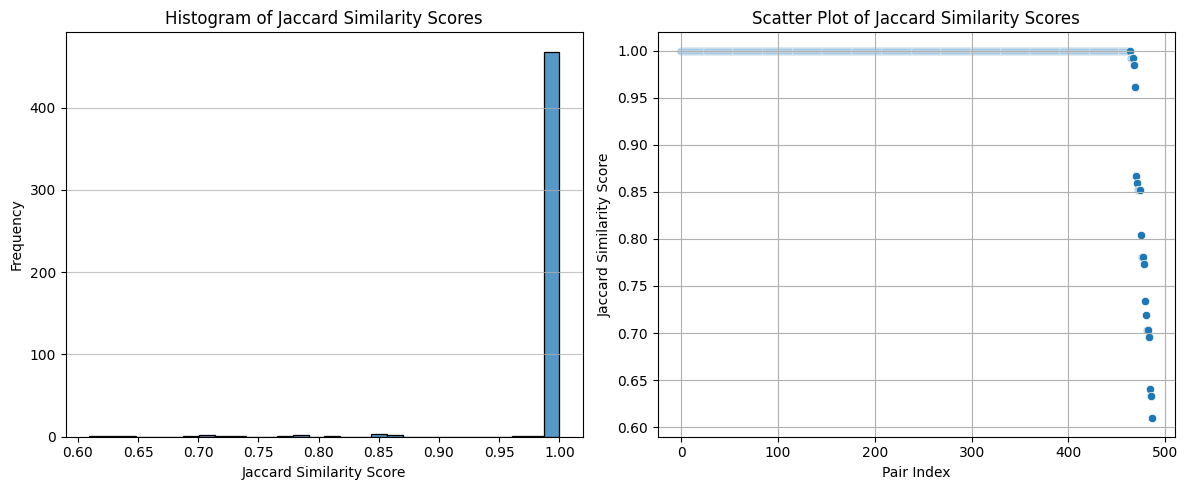

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract similarity scores from the final_similar_pairs list
similarity_scores = [score for _, _, score in final_similar_pairs]

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
sns.histplot(similarity_scores, bins=30, kde=False) # You can adjust the number of bins
plt.title('Histogram of Jaccard Similarity Scores')
plt.xlabel('Jaccard Similarity Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Scatter Plot
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
sns.scatterplot(x=range(len(similarity_scores)), y=similarity_scores)
plt.title('Scatter Plot of Jaccard Similarity Scores')
plt.xlabel('Pair Index')
plt.ylabel('Jaccard Similarity Score')
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()